In [2]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
from keras.utils import image_dataset_from_directory

In [4]:
ds_train = image_dataset_from_directory('../data/french_bird_db_25_50_cleaned', labels='inferred', image_size=(300, 300), validation_split=0.2, subset="training",
seed=42,)

ds_test = image_dataset_from_directory('../data/french_bird_db_25_50_cleaned', labels='inferred', image_size=(300, 300), validation_split=0.2, subset="validation",
seed=42,)

Found 1250 files belonging to 25 classes.
Using 1000 files for training.
Found 1250 files belonging to 25 classes.
Using 250 files for validation.


2024-07-02 13:59:51.857840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


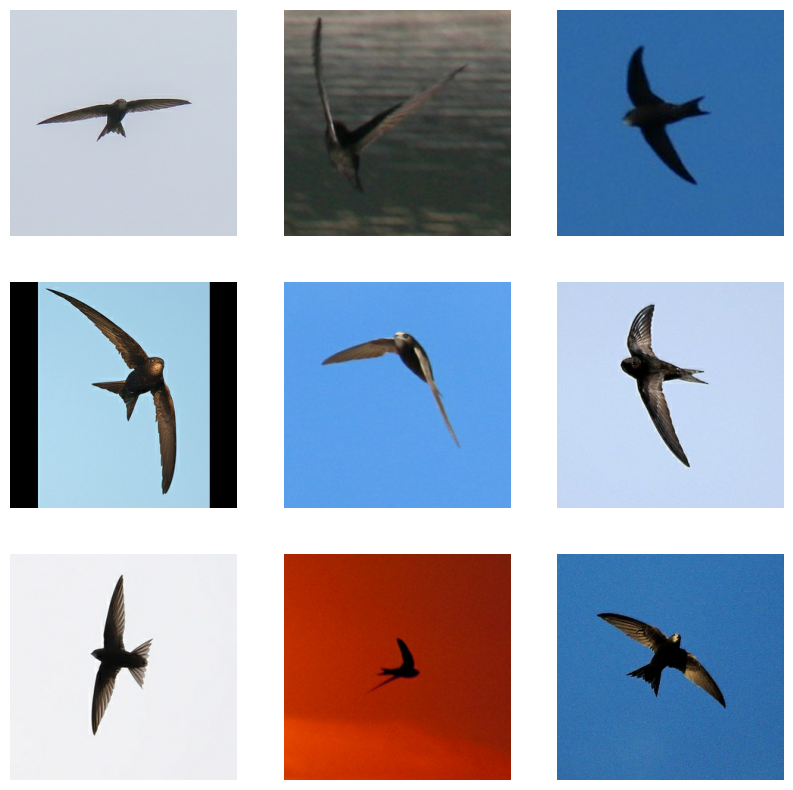

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [6]:
# Obtenir le nombre de classes à partir de ds
num_classes = len(ds_train.class_names)
print('Nombre de classes :', num_classes)

Nombre de classes : 25


In [7]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard

In [8]:
import tensorflow as tf

# Convertir les étiquettes cibles en vecteurs one-hot
ds_train = ds_train.map(lambda x, y: (x, tf.one_hot(y, num_classes)))
ds_test = ds_test.map(lambda x, y: (x, tf.one_hot(y, num_classes)))

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

tf.config.list_physical_devices()

# Charger le modèle ResNet50 pré-entraîné avec les poids ImageNet
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(300, 300, 3))

# Ajouter une couche de pooling global pour réduire la dimensionalité
x = base_model.output
x_2 = GlobalAveragePooling2D()(x)

x_3 = Dense(num_classes, activation='relu')(x_2)

# Ajouter une couche dense pour effectuer la classification
output = Dense(num_classes, activation='softmax')(x_3)

# Créer le modèle final en combinant le modèle de base et les couches supplémentaires
model = Model(inputs=base_model.input, outputs=output)

# Geler les couches du modèle de base pour éviter de les entraîner
for layer in base_model.layers:
    layer.trainable = False

# Compiler le modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=10),
             TensorBoard(log_dir='./logs/batch-100', histogram_freq=0, write_graph=True, write_images=True)]


# Entraîner le modèle sur votre dataset avec le callback personnalisé

history = model.fit(ds_train, epochs=10, batch_size=100, callbacks=callbacks, validation_data=ds_test)

Epoch 1/10


2024-07-02 13:59:55.616339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.0326 - loss: 3.3322 - val_accuracy: 0.0320 - val_loss: 3.2197
Epoch 2/10
25/32 ━━━━━━━━━━━━━━━━━━━━ 5s 739ms/step - accuracy: 0.0472 - loss: 3.2186